In [204]:
import pandas as pd
import numpy as np
from numpy import savetxt
from tqdm import tqdm, tqdm_notebook
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)
import sys
import itertools
import seaborn as sns

In [205]:
import econml
import warnings
#warnings.filterwarnings('ignore')

In [206]:
# Main imports
from econml.ortho_forest import DMLOrthoForest, DROrthoForest, DiscreteTreatmentOrthoForest
from econml.causal_tree import CausalTree
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV

from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter
import graphviz

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt

%matplotlib inline

# A few more imports
import os
import pandas as pd
import urllib.request
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [207]:
case_id_col = "Case ID"
activity_col = "Activity"
resource_col = "org:resource"
timestamp_col = "time:timestamp"

treatment = 'treatment'
outcome = 'duration'

In [208]:
dynamic_cat_cols = ['Activity', 'org:resource']
static_cat_cols = ['(case)_Item_Type', '(case)_Spend_area_text', '(case)_Sub_spend_area_text', '(case)_Vendor',
                   '(case)_GR-Based_Inv__Verif_', '(case)_Spend_classification_text', '(case)_Item_Category', '(case)_Company',
                   '(case)_Name', '(case)_Document_Type']
dynamic_num_cols = ['Cumulative_net_worth_(EUR)', 'open_cases', 'month', 'weekday', 'hour', 'timesincelastevent', 'timesincecasestart']
static_num_cols = ['timesincefirstcase', '(case)_Item', 'duration', 'treatment']

cat_cols = dynamic_cat_cols + static_cat_cols
num_cols = dynamic_num_cols + static_num_cols

In [209]:
tqdm.pandas()

/home/iverenich/anaconda3/lib/python3.7/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [210]:
def read_data(file):
    df = pd.read_csv(file,sep=',',compression="zip")
    #df = pd.read_csv(file)
    return df

In [ ]:
def get_treatment(optionals, df):
    df['treatment'] = 0
    for o in optionals:
        df2 = df[df[activity_col] == o]
        case_ids = list(set(df2[case_id_col]))
        print(len(case_ids))
        df.loc[df[case_id_col].isin(case_ids),"treatment"] = 1
        
    
    return df

In [ ]:
def keep_first(group):
    return group.head(1)

def get_activity_time(activity, df):
    df2 = df[df['Activity'] == activity]
    df2 = df2.groupby('Case ID').apply(keep_first)
    
    df_new = pd.DataFrame(df2[['Case ID', 'timesincecasestart']])
    df_new.reset_index(drop=True, inplace=True)
    df_new.rename(columns = {'timesincecasestart':'treatment'}, inplace = True)
    df_new['treatment'] = df_new['treatment']/1440
    
    df3 = pd.merge(df_new, df, on='Case ID', how = 'outer')
    df3 = df3.dropna(subset=['treatment'])
    
    return df3

In [211]:
data = 'BPI2019_ready.zip'
df = read_data(data)

In [212]:
df = df[df["duration"] < 2 * 365]
df = df[df["duration"] > 0]

In [ ]:
optionals = ['Change Quantity'] 
# 'Change Quantity', 'Change Delivery Indicator', 'Change Price', 'Change Approval for Purchase Order',
# 'Change Storage Location', 'Change payment term'  

df = get_treatment(optionals, df) 

In [ ]:
# some additional processing to remove changes at the beginning
case_ids = df[(df[activity_col] == 'Change Quantity') & (df['event_nr']==1)][case_id_col].unique()
df = df[~df[case_id_col].isin(case_ids)]
df = df.groupby(case_id_col).apply(lambda x: x.sort_values('event_nr')).reset_index(drop=True)

In [ ]:
case_ids = df[(df[activity_col] == 'Change Quantity') & (df['nr_event']==1)][case_id_col].unique()
df = df[~df[case_id_col].isin(case_ids)]
df = df.groupby(case_id_col).apply(lambda x: x.sort_values('event_nr')).reset_index(drop=True)

In [ ]:
case_ids = df[(df[activity_col] == 'Clear Invoice') & (df['nr_event']==1)][case_id_col].unique()
case_ids2 = df[(df[activity_col] == 'Record Goods Receipt') & (df['nr_event']==1)][case_id_col].unique()
df = df[(df[case_id_col].isin(case_ids)) | (df[case_id_col].isin(case_ids2))]

In [ ]:
resource_freq_threshold = 15
max_category_levels = 10

# set infrequent factor levels to "other"
for col in cat_cols:
    if col == resource_col:
        counts = df[col].value_counts()
        mask = df[col].isin(counts[counts >= resource_freq_threshold].index)
        df.loc[~mask, col] = "other"
    elif col != activity_col:
        counts = df[col].value_counts()
        mask = df[col].isin(counts.index[max_category_levels:])
        df.loc[mask, col] = "other"

In [ ]:
end_activity = [optionals[0]]
end_points = []
def cut_between_activities(group):
    end_activity_idxs = np.where(group[activity_col].isin(end_activity))[0]
    if len(end_activity_idxs) > 0:
        cut_idx_end = end_activity_idxs[0]
        end_points.append(cut_idx_end)
    else:

        cut_idx_end = int(np.random.choice(list(range(min(end_points), max(end_points))), 1))
        if group[group["nr_event"]==1].iloc[0]["event_nr"] <= cut_idx_end:
            cut_idx_end = min(end_points)
    
    return group[:cut_idx_end]

In [ ]:
# get prefixes for discreate treatment 
treated = df[df[treatment]==1]
control = df[df[treatment]==0]
dt_train_prefixes_t = treated.groupby(case_id_col).progress_apply(cut_between_activities)
dt_train_prefixes_c = control.groupby(case_id_col).progress_apply(cut_between_activities)

dt_prefixes = pd.concat([dt_train_prefixes_c, dt_train_prefixes_t], axis=0).reset_index(drop=True)

In [ ]:
# get prefixes for continuous treatment
# dt_prefixes = df.groupby(case_id_col).apply(cut_between_activities)
# dt_prefixes = dt_prefixes.reset_index(drop=True)

In [ ]:
import EncoderFactory

agg_encoder = EncoderFactory.get_encoder("agg", case_id_col=case_id_col, static_cat_cols=static_cat_cols,
                                         static_num_cols=static_num_cols, dynamic_cat_cols=dynamic_cat_cols,
                                         dynamic_num_cols=[])
last_encoder = EncoderFactory.get_encoder("last", case_id_col=case_id_col, static_cat_cols=static_cat_cols,
                                         static_num_cols=static_num_cols, dynamic_cat_cols=[],
                                         dynamic_num_cols=dynamic_num_cols)

In [ ]:
agg_encoded = agg_encoder.fit_transform(dt_prefixes)
last_encoded = last_encoder.fit_transform(dt_prefixes)

df_encoded = pd.merge(agg_encoded, last_encoded, on='Case ID')

In [ ]:
# create data with all features
df_case = df[df["nr_event"]==1]
df2 = df_case[[case_id_col]+static_cat_cols+static_num_cols]

df2 = pd.merge(df2, df_encoded, on='Case ID', how='inner')

In [ ]:
# distribution of treatment
df2['treatment'].value_counts()

In [ ]:
# if the dataset is too large
sampled = df2[df2[treatment]==0].sample(n=10000, random_state=123)
treated = df2[df2[treatment]==1]

df2 = pd.concat([sampled, treated], axis=0).reset_index(drop=True)

In [ ]:
df2 = df2.sort_values('timesincefirstcase', ascending=True, kind='mergesort')
df2 = df2.reset_index(drop=True)

In [ ]:
# save data for future runs
df2.to_csv('data_19_price_quantity_notRandom.csv', index=False)

In [214]:
df2 =pd.read_csv('data_19_price_clean_notRandom.csv')

In [20]:
df2['treatment'].value_counts()

0    10000
1     4830
Name: treatment, dtype: int64

In [21]:
df2['treatment'] = df2[treatment].replace({0:1, 1:0})

In [22]:
df2['treatment'].value_counts()

1    10000
0     4830
Name: treatment, dtype: int64

In [ ]:
dynamic_cat_cols = ['Activity', 'org:resource']
static_cat_cols = ['(case)_Item_Type', '(case)_Spend_area_text', '(case)_Sub_spend_area_text', '(case)_Vendor',
                   '(case)_GR-Based_Inv__Verif_', '(case)_Spend_classification_text', '(case)_Item_Category', '(case)_Company',
                   '(case)_Name', '(case)_Document_Type']
dynamic_num_cols = ['Cumulative_net_worth_(EUR)', 'open_cases', 'month', 'weekday', 'hour', 'timesincelastevent', 'timesincecasestart']
static_num_cols = ['timesincefirstcase', '(case)_Item', 'duration', 'treatment']

In [194]:
df2

,Case ID,(case)_Item_Type,(case)_Spend_area_text,(case)_Sub_spend_area_text,(case)_Vendor,(case)_GR-Based_Inv__Verif_,(case)_Spend_classification_text,(case)_Item_Category,(case)_Company,(case)_Name,(case)_Document_Type,timesincefirstcase,(case)_Item,duration,treatment,Activity_Block Purchase Order Item,Activity_Cancel Goods Receipt,Activity_Cancel Invoice Receipt,Activity_Cancel Subsequent Invoice,Activity_Change Approval for Purchase Order,Activity_Change Currency,Activity_Change Delivery Indicator,Activity_Change Quantity,Activity_Change Storage Location,Activity_Change payment term,Activity_Clear Invoice,Activity_Create Purchase Order Item,Activity_Create Purchase Requisition Item,Activity_Delete Purchase Order Item,Activity_Reactivate Purchase Order Item,Activity_Receive Order Confirmation,Activity_Record Goods Receipt,Activity_Record Invoice Receipt,Activity_Record Service Entry Sheet,Activity_Record Subsequent Invoice,Activity_Release Purchase Order,Activity_Release Purchase Requisition,Activity_Remove Payment Block,Activity_SRM: Awaiting Approval,Activity_SRM: Change was Transmitted,Activity_SRM: Complete,Activity_SRM: Created,Activity_SRM: Deleted,Activity_SRM: Document Completed,Activity_SRM: In Transfer to Execution Syst.,Activity_SRM: Ordered,Activity_Set Payment Block,Activity_Update Order Confirmation,Activity_Vendor creates debit memo,Activity_Vendor creates invoice,org:resource_NONE,org:resource_batch_00,org:resource_batch_01,org:resource_batch_02,org:resource_batch_03,org:resource_batch_04,org:resource_batch_05,org:resource_batch_06,org:resource_batch_07,org:resource_batch_08,org:resource_batch_11,org:resource_batch_12,org:resource_batch_13,org:resource_batch_16,org:resource_batch_17,org:resource_other,org:resource_user_000,org:resource_user_001,org:resource_user_002,org:resource_user_004,org:resource_user_005,org:resource_user_006,org:resource_user_007,org:resource_user_008,org:resource_user_009,org:resource_user_010,org:resource_user_011,org:resource_user_012,org:resource_user_013,org:resource_user_014,org:resource_user_015,org:resource_user_016,org:resource_user_018,org:resource_user_019,org:resource_user_020,org:resource_user_022,org:resource_user_023,org:resource_user_024,org:resource_user_025,org:resource_user_027,org:resource_user_029,org:resource_user_030,org:resource_user_031,org:resource_user_032,org:resource_user_033,org:resource_user_034,org:resource_user_035,org:resource_user_036,org:resource_user_037,org:resource_user_038,org:resource_user_039,org:resource_user_040,org:resource_user_041,org:resource_user_042,org:resource_user_043,org:resource_user_044,org:resource_user_045,org:resource_user_046,org:resource_user_047,org:resource_user_048,org:resource_user_049,org:resource_user_050,org:resource_user_051,org:resource_user_052,org:resource_user_053,org:resource_user_054,org:resource_user_056,org:resource_user_057,org:resource_user_058,org:resource_user_059,org:resource_user_060,org:resource_user_061,org:resource_user_062,org:resource_user_063,org:resource_user_064,org:resource_user_065,org:resource_user_066,org:resource_user_067,org:resource_user_068,org:resource_user_070,org:resource_user_071,org:resource_user_072,org:resource_user_073,org:resource_user_074,org:resource_user_075,org:resource_user_076,org:resource_user_077,org:resource_user_078,org:resource_user_079,org:resource_user_080,org:resource_user_082,org:resource_user_084,org:resource_user_085,org:resource_user_086,org:resource_user_087,org:resource_user_088,org:resource_user_089,org:resource_user_090,org:resource_user_091,org:resource_user_092,org:resource_user_093,org:resource_user_094,org:resource_user_095,org:resource_user_096,org:resource_user_097,org:resource_user_098,org:resource_user_099,org:resource_user_100,org:resource_user_101,org:resource_user_102,org:resource_user_103,org:resource_user_104,org:resource_user_105,org:resource_user_106,org:resource_user_107,org:resource_user_108,org:resource_user_109,org:resource_user_110,org:res

In [195]:
df2.columns.get_loc("Cumulative_net_worth_(EUR)")

425

In [197]:
df2_true = df2

In [192]:
df2 = df2_true

In [198]:
df2 = pd.concat([df2.iloc[:,0:50], df2.iloc[:,425:432]], axis=1)

In [199]:
# Prepare data for time of activity treatment
train, test = train_test_split(df2, test_size=0.2, shuffle=False)
train, valid = train_test_split(train, test_size=0.2, shuffle=False)
features = train.drop([outcome, treatment], axis=1)
features_test = valid.drop([outcome, treatment], axis=1)


cat_confound_cols = ['(case)_Item_Type',  '(case)_Spend_area_text', '(case)_Sub_spend_area_text',
                     '(case)_Vendor', '(case)_GR-Based_Inv__Verif_', '(case)_Spend_classification_text',
                     '(case)_Item_Category','(case)_Name', '(case)_Company', '(case)_Document_Type', '(case)_Item']
num_confound_cols = features.columns.difference(cat_confound_cols)


cat_hetero_cols = ['(case)_Item_Type', '(case)_Spend_area_text', '(case)_Sub_spend_area_text',
                   '(case)_Vendor', '(case)_GR-Based_Inv__Verif_', '(case)_Spend_classification_text',
                   '(case)_Item_Category', '(case)_Name', '(case)_Company', '(case)_Document_Type', '(case)_Item']
num_hetero_cols = features.columns.difference(cat_hetero_cols)
#num_hetero_cols = ['Cumulative_net_worth_(EUR)']

Y = train[outcome].to_numpy()
T = train[treatment].to_numpy()
scaler = StandardScaler()
W1 = scaler.fit_transform(features[[c for c in num_confound_cols]].to_numpy())
W2 = pd.get_dummies(features[cat_confound_cols]).to_numpy()
W = np.concatenate([W1, W2], axis=1)
X1 = scaler.fit_transform(features[[c for c in num_hetero_cols]].to_numpy())
X2 = pd.get_dummies(features[cat_hetero_cols]).to_numpy()
X = np.concatenate([X1, X2], axis=1)

X1_test = scaler.fit_transform(features_test[[c for c in num_hetero_cols]].to_numpy())
X2_test = pd.get_dummies(features_test[cat_hetero_cols]).to_numpy()
X_test = np.concatenate([X1_test, X2_test], axis=1)

tmp = pd.DataFrame(X)
tmp2 = pd.DataFrame(X_test)

# Get missing columns in the training test
missing_cols = set( tmp.columns ) - set( tmp2.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    tmp2[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
tmp2 = tmp2[tmp.columns]

X_test = tmp2.to_numpy()

In [200]:
print(X.shape)
print(X_test.shape)

(9491, 108)
(2373, 108)


In [125]:
# Define some parameters
N_trees = [200]
Min_leaf_size = [10]
Max_depth = [10]
Subsample_ratio = [0.7]
Lambda_reg= [0.01]

In [ ]:
Ylog = np.log(Y)

(200, 10, 10, 0.7, 0.01)


/home/iverenich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: X and W should be passed by keyword only. In a future release we will disallow passing X and W by position.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:   37.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:   37.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Par

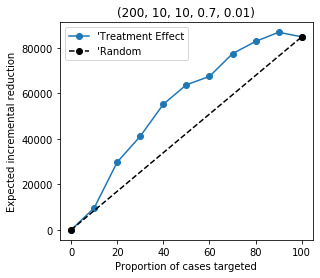

In [59]:
for i in itertools.product(N_trees, Min_leaf_size, Max_depth, Subsample_ratio, Lambda_reg):
    print(i)
    n_trees = i[0]
    min_leaf_size = i[1]
    max_depth = i[2]
    subsample_ratio = i[3]
    lambda_reg = i[4]
    est = DMLOrthoForest(
        n_trees=n_trees, min_leaf_size=min_leaf_size, max_depth=max_depth, 
        subsample_ratio=subsample_ratio, discrete_treatment=True,
        model_T=LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'),
        model_Y=Lasso(alpha=lambda_reg, ),
        model_T_final=LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'), 
        model_Y_final=WeightedLasso(alpha=lambda_reg),
        random_state=200
       )
    
    ortho_model = est.fit(Y, T, X, W)
    batches = np.array_split(X_test, X_test.shape[0] / 100)
    treatment_effects = est.const_marginal_effect(batches[0])
    ii = 0
    for batch in batches[1:]:
#         print(ii)
        estimates = est.const_marginal_effect(batch)
        treatment_effects = np.append(treatment_effects, estimates)
        ii += 1
    df_results = valid
    df_results['Treatment Effects'] = treatment_effects
    
    net_value = [0]

    percentages = [10,20,30,40,50,60,70,80,90,100]

    for n in percentages:
        num = int(len(df_results)*(n/100))
        top_n = df_results.nsmallest(num,'Treatment Effects')
        n_treated = top_n[top_n['treatment']==1].shape[0]
        n_control = top_n[top_n['treatment']==0].shape[0]
        scale_factor = n_treated/n_control

        treated = top_n[top_n['treatment']==1]['duration'].sum()
        control = top_n[top_n['treatment']==0]['duration'].sum()

        reduction = (scale_factor*control) - treated 
        net_value.append(reduction)
        
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot([0]+percentages, net_value, label="'Treatment Effect", marker="o")
    plt.plot([0,percentages[9]], [0,net_value[10]], label="'Random",  marker="o", color='Black',
             linestyle='dashed')
    plt.xlabel('Proportion of cases targeted')
    plt.ylabel('Expected incremental reduction')
    plt.legend(loc='best')
    plt.title(i)

    plt.savefig('Results/Change_quantity_valid2%s.png'%str(i), format='png', dpi=300)

In [ ]:
df_results.to_csv('Results/Change_quantity_valid%s.csv'%str(i), index=False)

Text(0.5, 1.0, 'v/c=1')

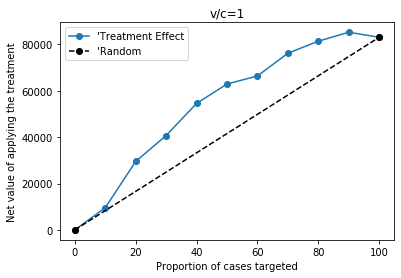

In [65]:
net_value = [0]
v = 1
c = 1

percentages = [10,20,30,40,50,60,70,80,90,100]

for n in percentages:
    num = int(len(df_results)*(n/100))
    top_n = df_results.nsmallest(num,'Treatment Effects')
    n_treated = top_n[top_n['treatment']==1].shape[0]
    n_control = top_n[top_n['treatment']==0].shape[0]
    scale_factor = n_treated/n_control

    treated = top_n[top_n['treatment']==1]['duration'].sum()
    control = top_n[top_n['treatment']==0]['duration'].sum()

    reduction = (scale_factor*control) - treated
    net_val = (reduction*v) - (n_treated*c) 
    net_value.append(net_val)
    #net_value.append(reduction)

# plt.figure(figsize=(10, 4))
# plt.subplot(1, 2, 1)
plt.plot([0]+percentages, net_value, label="'Treatment Effect", marker="o")
plt.plot([0,percentages[9]], [0,net_value[10]], label="'Random",  marker="o", color='Black',
         linestyle='dashed')
plt.xlabel('Proportion of cases targeted')
plt.ylabel('Net value of applying the treatment')
plt.legend(loc='best')
plt.title('v/c=1')

# plt.savefig('Results/Change_price_valid_vc=1_%s.png'%str(i), format='png', dpi=300)

In [26]:
# preparing the test set
f_test = test.drop([outcome, treatment], axis=1)
X1_test = scaler.fit_transform(f_test[[c for c in num_hetero_cols]].to_numpy())
X2_test = pd.get_dummies(f_test[cat_hetero_cols]).to_numpy()
X_test = np.concatenate([X1_test, X2_test], axis=1)

tmp = pd.DataFrame(X)
tmp2 = pd.DataFrame(X_test)

# Get missing columns in the training test
missing_cols = set( tmp.columns ) - set( tmp2.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    tmp2[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
tmp2 = tmp2[tmp.columns]

X_test = tmp2.to_numpy()

(200, 10, 10, 0.7, 0.01)


/home/iverenich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: X and W should be passed by keyword only. In a future release we will disallow passing X and W by position.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:   42.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:   40.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Par

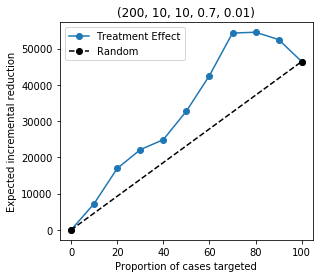

In [28]:
# curve for the test set
for i in itertools.product(N_trees, Min_leaf_size, Max_depth, Subsample_ratio, Lambda_reg):
    print(i)
    n_trees = i[0]
    min_leaf_size = i[1]
    max_depth = i[2]
    subsample_ratio = i[3]
    lambda_reg = i[4]
    est = DMLOrthoForest(
        n_trees=n_trees, min_leaf_size=min_leaf_size, max_depth=max_depth, 
        subsample_ratio=subsample_ratio, discrete_treatment=True,
        model_T=LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'),
        model_Y=Lasso(alpha=lambda_reg, ),
        model_T_final=LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'), 
        model_Y_final=WeightedLasso(alpha=lambda_reg),
        random_state=200
       )
    
    ortho_model = est.fit(Y, T, X, W)
    batches = np.array_split(X_test, X_test.shape[0] / 100)
    treatment_effects = est.const_marginal_effect(batches[0])
    ii = 0
    for batch in batches[1:]:
#         print(ii)
        estimates = est.const_marginal_effect(batch)
        treatment_effects = np.append(treatment_effects, estimates)
        ii += 1
    df_results = test
    df_results['Treatment Effects'] = treatment_effects
    
    # Calculate default (90%) confidence intervals for the default treatment points T0=0 and T1=1
#     te_lower, te_upper = est.effect_interval(batches[0])
#     ii = 0
#     for batch in batches[1:]:
#         print(ii)
#         lower, upper = est.effect_interval(batch)
#         te_lower = np.append(te_lower, lower)
#         te_upper = np.append(te_upper, upper)
#         ii += 1
        
#     df_results['te_lower'] = te_lower
#     df_results['te_upper'] = te_upper
#     df_results['Interval Length'] = df_results['te_upper'] - df_results['te_lower']
    
    net_value = [0]
    net_value2 = [0]
    net_value3 = [0]

    percentages = [10,20,30,40,50,60,70,80,90,100]

    for n in percentages:
        num = int(len(df_results)*(n/100))
        top_n = df_results.nlargest(num,'Treatment Effects')
        n_treated = top_n[top_n['treatment']==1].shape[0]
        n_control = top_n[top_n['treatment']==0].shape[0]
        scale_factor = n_treated/n_control

        treated = top_n[top_n['treatment']==1]['duration'].sum()
        control = top_n[top_n['treatment']==0]['duration'].sum()

        reduction = (scale_factor*control) - treated 
        net_value.append(reduction)
        
#     for n in percentages:
#         num = int(len(df_results)*(n/100))
#         top_n = df_results.nsmallest(num,'te_lower')
#         n_treated = top_n[top_n['treatment']==1].shape[0]
#         n_control = top_n[top_n['treatment']==0].shape[0]
#         scale_factor = n_treated/n_control

#         treated = top_n[top_n['treatment']==1]['duration'].sum()
#         control = top_n[top_n['treatment']==0]['duration'].sum()

#         reduction = (scale_factor*control) - treated 
#         net_value2.append(reduction)
        
#     for n in percentages:
#         num = int(len(df_results)*(n/100))
#         top_n = df_results.nsmallest(num,'te_upper')
#         n_treated = top_n[top_n['treatment']==1].shape[0]
#         n_control = top_n[top_n['treatment']==0].shape[0]
#         scale_factor = n_treated/n_control

#         treated = top_n[top_n['treatment']==1]['duration'].sum()
#         control = top_n[top_n['treatment']==0]['duration'].sum()

#         reduction = (scale_factor*control) - treated 
#         net_value3.append(reduction)
        
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot([0]+percentages, net_value, label="Treatment Effect", marker="o")
#     plt.plot([0]+percentages, net_value2, label="TE Lower bound", marker="o", color='Green')
#     plt.plot([0]+percentages, net_value3, label="TE Upper bound", marker="o", color='Red')
    plt.plot([0,percentages[9]], [0,net_value[10]], label="Random",  marker="o", color='Black',
             linestyle='dashed')
    plt.xlabel('Proportion of cases targeted')
    plt.ylabel('Expected incremental reduction')
    plt.legend(loc='best')
    plt.title(i)

    plt.savefig('Results/Change_price_test4_%s.png'%str(i), format='png', dpi=300)

In [66]:
df_results = pd.read_csv('Results/Change_price_test_latest_(200, 10, 10, 0.7, 0.01).csv')

7106.994588122601
16576.45590853284
21552.916499231455
24097.49208057396
31729.514060570957
41339.610377634715
52872.08822141316
52896.03817573884
50709.49124097611
44504.784074844676
6998.994588122601
16329.25590853284
21171.316499231456
23567.09208057396
31055.714060570957
40528.41037763472
51935.488221413165
51829.238175738836
49532.89124097611
43229.784074844676
6728.994588122601
15711.25590853284
20217.316499231456
22241.09208057396
29371.214060570957
38500.41037763472
49593.988221413165
49162.238175738836
46591.39124097611
40042.284074844676
6188.994588122601
14475.25590853284
18309.316499231456
19589.09208057396
26002.214060570957
34444.41037763472
44910.988221413165
43828.238175738836
40708.39124097611
33667.284074844676
5648.994588122601
13239.25590853284
16401.316499231456
16937.09208057396
22633.214060570957
30388.41037763472
40227.988221413165
38494.238175738836
34825.39124097611
27292.284074844676


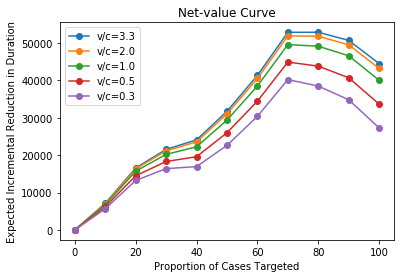

In [119]:
value = [1]
cost = [0.3,0.5,1,2,3]

percentages = [10,20,30,40,50,60,70,80,90,100]

for i in itertools.product(value, cost):
    v = i[0]
    c = i[1]
    net_value = [0]
    for n in percentages:
        num = int(len(df_results)*(n/100))
        top_n = df_results.nlargest(num,'Treatment Effects')
        n_treated = top_n[top_n['treatment']==1].shape[0]
        n_control = top_n[top_n['treatment']==0].shape[0]
        scale_factor = n_treated/n_control

        treated = top_n[top_n['treatment']==1]['duration'].sum()
        control = top_n[top_n['treatment']==0]['duration'].sum()

        reduction = (scale_factor*control) - treated
        net_val = (reduction*v) - (3*n_treated*c)
        print(net_val)
        net_value.append(net_val)
    #     net_value.append(reduction)

    #normed = norm = [(float(i)-min(net_value))/(max(net_value)-min(net_value)) for i in net_value]


    # plt.figure(figsize=(10, 4))
    # plt.subplot(1, 2, 1)
    plt.plot([0]+percentages, net_value, label="v/c=%s"%str(round(v/c,1)), marker="o")
    #     plt.plot([0]+percentages, net_value2, label="TE Lower bound", marker="o", color='Green')
    #     plt.plot([0]+percentages, net_value3, label="TE Upper bound", marker="o", color='Red')
#     plt.plot([0,percentages[9]], [0,net_value[10]], label="Random Policy",  marker="o", color='Black',
#              linestyle='dashed')
    plt.xlabel('Proportion of Cases Targeted')
    plt.ylabel('Expected Incremental Reduction in Duration')
    plt.legend(loc='best')
    plt.title('Net-value Curve')

plt.savefig('Results/Change_price_netvals.png', format='png', dpi=300)

In [ ]:
# non cumulative plot
net_value = []

percentages = [10,20,30,40,50,60,70,80,90,100]
num_rows = df_results.shape[0]
df_results = df_results.sort_values('Treatment Effects', ascending=False)

#non cumulative version
for n in percentages:
    top_n = df_results.iloc[round(num_rows * (n-10)/100) : round(num_rows * (n)/100) ,:]
    n_treated = top_n[top_n['treatment']==1].shape[0]
    n_control = top_n[top_n['treatment']==0].shape[0]
    scale_factor = n_treated/n_control

    treated = top_n[top_n['treatment']==1]['duration'].sum()
    control = top_n[top_n['treatment']==0]['duration'].sum()

    reduction = (scale_factor*control) - treated 
    net_value.append(reduction)
        
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(percentages, net_value, label="'Treatment Effect", marker="o")
plt.plot([percentages[0],percentages[9]], [net_value[0],net_value[9]], label="'Treatment Effect",  marker="o", color='Black',
         linestyle='dashed')
plt.title(i)
plt.savefig('Results/Change_price_flipped_train_nonCumulative_%s.png'%str(i), format='png', dpi=300)

In [ ]:
# save results

df_results = valid
df_results['Treatment Effects'] = treatment_effects

# df_results['te_lower'] = te_lower
# df_results['te_upper'] = te_upper
# df_results['Interval Length'] = df_results['te_upper'] - df_results['te_lower']

df_results.to_csv('BPI19_skip_change_quantity_forQini.csv', index=False)

In [201]:
for i in itertools.product(N_trees, Min_leaf_size, Max_depth, Subsample_ratio, Lambda_reg):
    print(i)
    n_trees = i[0]
    min_leaf_size = i[1]
    max_depth = i[2]
    subsample_ratio = i[3]
    lambda_reg = i[4]
    est = DMLOrthoForest(
        n_trees=n_trees, min_leaf_size=min_leaf_size, max_depth=max_depth, 
        subsample_ratio=subsample_ratio, discrete_treatment=True,
        model_T=LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'),
        model_Y=Lasso(alpha=lambda_reg, ),
        model_T_final=LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'), 
        model_Y_final=WeightedLasso(alpha=lambda_reg),
        random_state=200
       )
    
    ortho_model = est.fit(Y, T, X, W)

(200, 10, 10, 0.7, 0.01)


/home/iverenich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: X and W should be passed by keyword only. In a future release we will disallow passing X and W by position.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   24.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   24.3s finished


In [202]:
# For sensitivity analysis
Y_hat, propensities = est.nuisance_estimator(Y, np.reshape(T, (-1, 1)), X, W)
df_yhat = pd.DataFrame(Y_hat)

df_propensity = pd.DataFrame(propensities)
df_yhat["treatment"] = train.reset_index()["treatment"]

# df_yhat["selected"] = 0
# for i,row in df_yhat.iterrows():
#     df_yhat.loc[i,"selected"] = row[ row["treatment"] ]
    
df_sensitivity = pd.concat([df_propensity[0], df_yhat[0], train.reset_index()[treatment],
                            train.reset_index()[outcome]], keys=['g', 'Q', 't', 'y'], axis = 1)

df_sensitivity.to_csv('Resources.csv', index=False)

/home/iverenich/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/iverenich/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [203]:
df_results['duration'].mean()

150.2241449389377

In [ ]:
# load results later and compare similarity matrices

df_old = pd.read_csv('BPI17_skip_call_incomplete_withCI.csv')
te = df_old.loc[:,['Treatment Effects']]
df_old = df_results.drop(["duration", "treatment", "Case ID"], axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


cat_hetero_cols = ['LoanGoal', 'ApplicationType']
num_hetero_cols = df_old.columns.difference(cat_hetero_cols)


X1_test = scaler.fit_transform(df_old[[c for c in num_hetero_cols]].to_numpy())
X2_test = pd.get_dummies(df_old[cat_hetero_cols]).to_numpy()
X_test = np.concatenate([X1_test, X2_test], axis=1)

df_old = pd.DataFrame(X_test)

In [ ]:
from scipy.spatial.distance import pdist,squareform

dist_fv = pd.DataFrame(squareform(pdist(df_old)))
dist_te = pd.DataFrame(squareform(pdist(te)))

In [ ]:
import seaborn as sns

sns.heatmap(dist_fv.iloc[:300,:300],cmap="Greens")

In [ ]:
sns.heatmap(dist_te.iloc[:300,:300],cmap="Greens")